In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as ppi_vgg16
from tensorflow.keras.models import Sequential
import cv2 

import os
import time

from itertools import permutations
import warnings

3.4.2


In [ ]:
warnings.filterwarnings("ignore")

# CONSTANTS

In [73]:
RAW_DATA_FILE_PATH = 'data/raw/'                # path to cleaned data folder
CLEANED_DATA_FILE_PATH = 'data/cleaned/'        # path to cleaned data folder
IMAGES_DIR = "data/raw/"                          # full set of 1050 images
#IMAGES_DIR = "images_subset/"                   # subset of images

# FUNCTIONS

In [74]:
def construct_category(str_breadcrumbs):
    # remove start [" and end "]
    str_breadcrumbs = str_breadcrumbs.replace('["','')
    str_breadcrumbs = str_breadcrumbs.replace('"]','')
    # split on ' >> '
    crumbs = str_breadcrumbs.split(' >> ')

    # return only first category
    return crumbs[0]


def create_vec_df_to_save(array,images,df):
    df_vec = pd.DataFrame(array)
    df_vec['filename'] = images
    df_vec = df[['image','uniq_id','product_category']].merge(df_vec, how='right', left_on='image', right_on='filename')
    df_vec = df_vec.drop(columns=['filename','image'])
    df_vec.head(3)
    return df_vec

def preprocess_images(ppi,my_new_model):
    feature_list = []
    images = [f for f in os.listdir(IMAGES_DIR)]
    image_num = 0
    for image in images:
        image_num = image_num + 1
        if image_num%10 == 0 : print(image_num,image)
        file = IMAGES_DIR+image
        #print(file)
        im = cv2.imread(file)
        im = cv2.resize(im,(256,256))
        img = ppi(np.expand_dims(im.copy(), axis=0))
        feature = my_new_model.predict(img)
        feature_np = np.array(feature)
        feature_list.append(feature_np.flatten())
    array = np.array(feature_list)
    return array, images


In [75]:
def run_model(model,ppi):
    start = time.time()
    my_new_model = Sequential()
    my_new_model.add(model)
    # Say not to train first layer (ResNet) model. It is already trained
    my_new_model.layers[0].trainable = False
    array, images = preprocess_images(ppi,my_new_model)
    return array,images


# PROJECT 8

In [76]:
# read images, create df of filenames, and class (which type)

fv = pd.DataFrame(columns=['filename','fv_class'])

for filename in os.listdir(RAW_DATA_FILE_PATH):
    f = os.path.join(RAW_DATA_FILE_PATH, filename)
    # checking if it is a file
    if os.path.isfile(f):
        fv_class = filename[:filename.find(' ')]
        fv.loc[len(fv)] = [filename,fv_class]
        
fv

,filename,fv_class
0,Banana 0_100.jpg,Banana
1,Banana 128_100.jpg,Banana
2,Banana 180_100.jpg,Banana
3,Banana 270_100.jpg,Banana
4,Banana 35_100.jpg,Banana
5,Banana 90_100.jpg,Banana
6,Cauliflower 0_100.jpg,Cauliflower
7,Cauliflower 114_100.jpg,Cauliflower
8,Cauliflower 167_100.jpg,Cauliflower
9,Cauliflower 235_100.jpg,Cauliflower


# VECTORIZATION

## VGG16

In [77]:
model = VGG16(include_top=False, pooling='avg', weights='imagenet')
array,images = run_model(model,ppi_vgg16)

10 Cauliflower 235_100.jpg
20 Granny Smith 100_100.jpg
30 Pear 158_100.jpg


# CREATE DF FOR TSNE, PCA, KMEANS

In [78]:
# create df from model vector
df_vec = pd.DataFrame(array)

# add image filename
df_vec['filename'] = images

df_vec['fv_class'] = fv.fv_class
df_vec.tail()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,filename,fv_class
26,3.400645,0.000000,2.366819,0.368504,2.550495,1.132311,0.157406,0.248959,0.000000,0.828768,...,1.176907,0.185506,5.092254,1.215058,0.000000,0.000000,0.171087,0.0,Pear 118_100.jpg,Pear
27,1.988882,0.332160,2.170422,0.409024,2.337032,0.483578,0.108098,0.000000,0.133328,0.913934,...,1.508667,0.849734,3.996593,0.866202,0.000000,0.046472,0.209033,0.0,Pear 133_100.jpg,Pear
28,1.675247,0.135137,1.056939,0.715775,2.505499,0.610032,0.276875,0.177360,0.010623,0.670084,...,1.233358,0.322029,4.093109,1.134185,0.004168,0.000000,0.150460,0.0,Pear 148_100.jpg,Pear
29,2.175446,0.516710,2.501349,0.986106,1.569823,0.502298,1.194437,0.000000,0.117546,0.767123,...,0.974395,0.423638,5.339666,0.865014,0.000000,0.000000,0.052661,0.0,Pear 158_100.jpg,Pear
30,1.137218,0.000000,1.862713,0.140231,3.057057,0.685076,0.000000,0.454548,0.000000,1.192062,...,0.309300,0.056651,4.855635,1.008081,0.000000,0.000000,0.138792,0.0,Pear 17_100.jpg,Pear


# RUN PCA FOR REDUCTION

In [80]:
df_vec.shape

(31, 514)

In [81]:
pca = decomposition.PCA(n_components=0.99)
array_pca_out = pca.fit_transform(df_vec.drop(columns=['filename','fv_class']))
df_new = pd.DataFrame(array_pca_out)
df_new['filename'] = df_vec['filename']
df_new['fv_class'] = df_vec['fv_class']
df_new.shape

(31, 25)

# RUN TSNE FOR PLOTTING

In [82]:
df_mdl = df_new.drop(['filename', 'fv_class'], axis=1, errors='ignore')

In [83]:
tsne = manifold.TSNE(n_components=2, perplexity=100, n_iter=2000, 
                    init='random', random_state=42, learning_rate='auto')
projection = tsne.fit_transform(df_mdl)

# KMEANS

In [85]:
# run KMEANS, to produce the clustering using the tsne results as input
# print define Kmeans
kmeans = cluster.KMeans(n_clusters=5, n_init=100, random_state=42, init='k-means++')
kmeans.fit(df_mdl)


KMeans(n_clusters=5, n_init=100, random_state=42)

In [86]:
df_mdl['kmeans_cluster'] = kmeans.labels_
df_mdl['tsne1'] = pd.DataFrame(data=projection)[0]
df_mdl['tsne2'] = pd.DataFrame(data=projection)[1]

df_mdl['filename'] = df_vec['filename']
df_mdl['fv_class'] = df_vec['fv_class']

df_mdl.head(5)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,kmeans_cluster,tsne1,tsne2,filename,fv_class
0,-13.445768,28.239614,-10.660436,-9.676561,3.032860,1.948665,2.272466,0.572680,4.899180,-4.012837,...,-0.013202,3.728123,-0.624636,-0.991885,-3.104257,3,-1.176294,-2.649664,Banana 0_100.jpg,Banana
1,-9.528513,33.791370,-7.880566,-15.732278,-10.073254,-4.905876,-2.429302,-0.437181,-5.124746,2.000661,...,4.694873,8.208426,1.526045,1.746210,0.074067,3,-1.170382,-2.647987,Banana 128_100.jpg,Banana
2,-9.287179,20.528790,-7.583988,-6.991084,14.269303,18.321703,2.314918,-0.976992,0.578252,-6.357923,...,-0.515627,1.304176,-0.501988,-0.800421,-0.262201,3,-1.176730,-2.645480,Banana 180_100.jpg,Banana
3,-13.679565,31.402523,-10.529594,-14.269199,-2.204153,-2.502553,-0.133933,1.222026,1.713147,-3.330533,...,-2.571580,-6.592553,0.354569,3.453317,4.130130,3,-1.175944,-2.643760,Banana 270_100.jpg,Banana
4,-13.047629,14.865832,-4.829874,-3.293043,11.230541,19.767576,-0.606293,-2.445284,1.517169,12.026182,...,0.063448,-1.754209,0.567187,0.335454,1.046427,3,-1.170547,-2.648267,Banana 35_100.jpg,Banana


# MAP CLASSES

In [87]:
df_mdl['fv_class'] = pd.Categorical(df_mdl['fv_class'])
df_mdl['fv_class_code'] = df_mdl['fv_class'].cat.codes

In [89]:
# map real category labels to kmeans labels, based on the clustering
y_true = df_mdl.fv_class_code
y_pred = kmeans.labels_
best_precision = 0
for permutation in permutations(range(5), 5):
    y_pred_ = np.array([permutation[i] for i in y_pred])
    cm_precision = np.round(metrics.precision_recall_fscore_support(y_true,y_pred_,labels=permutation,average='weighted')[0],4)
    if cm_precision > best_precision: 
        best_precision = cm_precision
        best_permutation = permutation
y_pred_ = np.array([best_permutation[i] for i in y_pred])
cm_accuracy  = np.round(metrics.accuracy_score(y_true,y_pred_),4)

# produce confusion matrix / heatmap
cm = metrics.confusion_matrix(y_true, y_pred_,labels=best_permutation)

report = metrics.classification_report(y_true, y_pred_)
print (report)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         7

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



In [91]:
LIST_LABELS = [                                     
               'Banana',
               'Cauliflower',
               'Ginger',
               'Granny',
               'Pear'
               ]

columns = ''.join(str(x) for x in best_permutation)
columns

'14203'

In [92]:

df_cm = pd.DataFrame(cm, index = [label for label in LIST_LABELS],
                        columns = [i for i in columns])
                        


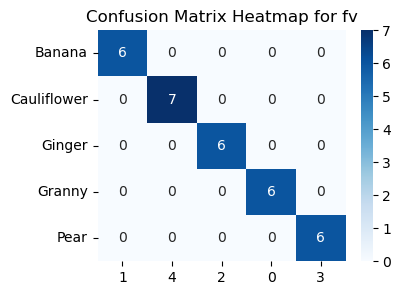

In [98]:
plt.figure(figsize = (4,3))
ax = sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
ax.set_title('Confusion Matrix Heatmap for fv')
plt.show()

# PLOT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Représentation des fv par clusters')

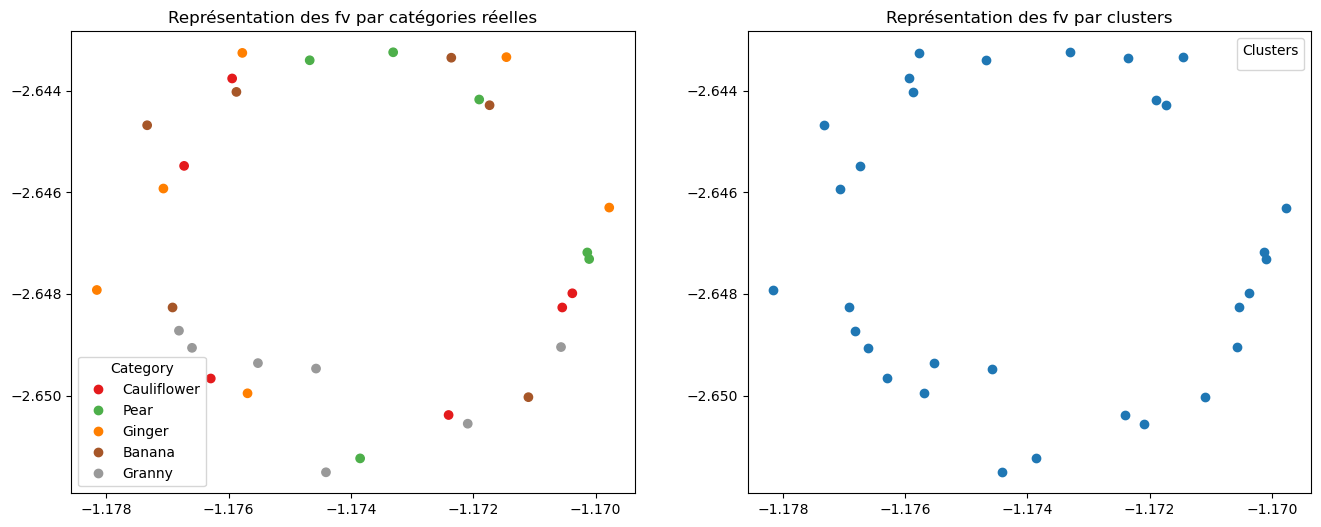

In [97]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
scatter = ax.scatter(df_mdl["tsne1"],df_mdl["tsne2"], c=df_mdl["fv_class_code"], cmap='Set1')
ax.legend(handles=scatter.legend_elements()[0], labels=set(df_mdl["fv_class"]), loc="best", title="Category")
plt.title('Représentation des fv par catégories réelles')

ax = fig.add_subplot(122)
scatter = ax.scatter(df_mdl["tsne1"],df_mdl["tsne2"])
ax.legend(handles=scatter.legend_elements()[0], labels=set(y_pred_), loc="best", title="Clusters")
plt.title('Représentation des fv par clusters')

